In [1]:
import pandas as pd
import numpy as np
from plotnine import *

In [2]:
player_buy_data=pd.read_csv(r'D:\mydata\Game_DataMining_With_R-master\Game_DataMining_With_R-master\data\第9章\玩家购物数据.csv')

In [3]:
player_buy_data.info

<bound method DataFrame.info of        player_id product_name  qty
0      107204535        感恩大礼包    1
1      107204535         新手礼包    1
2      213666611         8条钥匙    1
3      226500629      0.1元大礼包    1
4      226500629         8条钥匙    1
...          ...          ...  ...
8979  1030301589         8条钥匙    2
8980  1030393205      15000金币    1
8981  1030393205         8条钥匙    2
8982  1030393205         解锁滑板    1
8983  1030393221      0.1元大礼包    1

[8984 rows x 3 columns]>

In [4]:
#共有多少个玩家，公有多少个商品品类。
print(player_buy_data['player_id'].unique().size,player_buy_data['product_name'].unique().size)

6252 26


In [5]:
qty_data=player_buy_data.groupby(['product_name'])['qty'].sum()
print(qty_data,qty_data.sum(),player_buy_data['qty'].sum())

product_name
0.1元大礼包      806
10块滑板         93
15000金币     1426
15元大礼包         3
1条钥匙          88
20条钥匙        218
3000金币       308
38000金币      243
50条钥匙        743
60块滑板         84
70000金币      734
8元大礼包          4
8条钥匙        3202
双倍金币         551
快速复活         683
感恩大礼包         16
数据备份          65
新手礼包         431
正版激活          52
特殊滑板         333
特级大礼包          1
解锁滑板         427
超值大礼包        112
超级大礼包         33
限量版角色        875
首次复活0.1元       6
Name: qty, dtype: int64 11537 11537


In [6]:
qty_data=pd.DataFrame(qty_data).reset_index()
qty_data=qty_data.sort_values(by='qty',ascending=True)

#玩家购买产品数量分布

In [7]:
qty_data['product_name']=pd.Categorical(qty_data['product_name'],ordered=True,categories=qty_data['product_name'])
base_plot=(ggplot(qty_data[['product_name','qty']],aes('product_name','qty'))+coord_flip()+
           theme(text=element_text(family='SimHei'))+
           geom_bar(stat='identity',width=0.8,color='black',size=0.25,fill='blue',alpha=0.5))

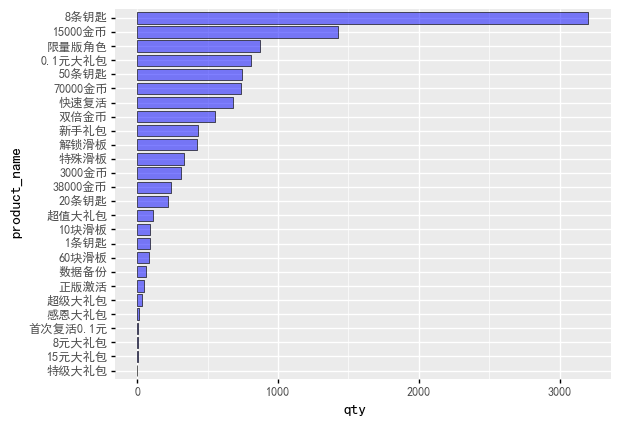

<ggplot: (-9223371923093625656)>

In [8]:
base_plot

可见，玩家购买道具频次从高到低是[8条钥匙，15000金币，0.1元大礼包，50条钥匙，7000金币]。

In [12]:
#对player_buy_data进行apriori关联算法分析。
data=player_buy_data[['player_id','product_name']]
data['product_name']=data['product_name'].apply(lambda x:','+x)
data=data.groupby(['player_id']).sum().reset_index()
data['product_name']=data['product_name'].apply(lambda x :[x[1:]])
data_list=list(data['product_name'])

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
data_translation=[]
for i in data_list:
    p=i[0].split(',')
    data_translation.append(p)
print('数据转换结果的前5个元素：\n',data_translation[0:5])

数据转换结果的前5个元素：
 [['感恩大礼包', '新手礼包'], ['8条钥匙'], ['0.1元大礼包', '8条钥匙', '限量版角色'], ['38000金币', '限量版角色', '新手礼包'], ['50条钥匙']]


In [14]:
from numpy import *
#自定义一个数据测试集
def loadDataSet():
    return [['a','c','e'],['b','d'],['b','c'],['a','b','c','d'],['a','b'],['b','c'],['a','b'],['a','b','c','e'],['a','b','c'],['a','c','e']]
#创建createC1,得到单个全集元素集合的列表。
def createC1(dataSet):
    C1=[]
    for transaction in dataSet:
        for item in transaction:
            if not [item] in C1:
                C1.append([item])
    C1.sort()
    return list(map(frozenset, C1))
#从候选K项集 到频繁K项集（支持度计算）
def scanD(D,CK,minSupport):
    ssCnt={}
    for tid in D:            #遍历数据集
        for can in CK:              #遍历候选项 
            if can.issubset(tid):    #候选项是否有数据集的各项
                if not can in ssCnt:
                    ssCnt[can]=1
                else:
                    ssCnt[can] += 1
    numItems=float(len(D))  #数据集大小
    retList=[]            #L1初始化
    supportData={}
    for key in ssCnt:
        support=ssCnt[key]/numItems    #计算支持度
        if support >= minSupport:
            retList.insert(0,key)      #满足条件加入到L1中
            supportData[key]=support
    return retList, supportData
def calSupport(D,CK,min_support):
    dict_sup={}
    for i in D:
        for j in CK:
            if j.issubset(i):
                if not j in dict_sup:
                    dict_sup[j]=1
                else:
                    dict_sup[j] +=1
    sumCount=float(len(D))
    supportData={}
    relist=[]
    for i in dict_sup:
        temp_sup=dict_sup[i]/sumCount
        if temp_sup>=min_support:
            relist.append(i)
            supportData[i]=temp_sup
    return relist, supportData
#改进剪枝算法
def aprioriGen(Lk,k):
    retList=[]
    lenLk=len(Lk)
    for i in range(lenLk):
        for j in range(i+1, lenLk):#两两组合遍历
            L1=list(Lk[i])[:k-2]
            L2=list(Lk[j])[:k-2]
            L1.sort()
            L2.sort()
            if L1==L2: #前K-1项相等，则可相乘，这样可防止重复项出现
                #进行剪枝（a1为k项集中的一个元素，b为它的所有k-1项子集）
                a=Lk[i]|Lk[j]  #a为frozenset（）的集合
                a1=list(a)
                b=[]
                #遍历取出每一个元素，转换为set，依次从a1中剔除该元素，并加入到b中
                for q in range(len(a1)):
                    t=[a1[q]]
                    tt=frozenset(set(a1)-set(t))
                    b.append(tt)
                t=0
                for w in b:
                    #当b（即所有K-1项子集）都是Lk（频繁的）子集，则保留，否则删除
                    if w in Lk:
                        t += 1
                if t==len(b):
                    retList.append(b[0]|b[1])
    return retList
def apriori(dataSet, minSupport=0.2):
    #前3条语句是对计算查找单个元素中的频繁项集
    C1=createC1(dataSet)
    D=list(map(set,dataSet)) #使用list转换为列表
    L1, supportData=calSupport(D,C1,minSupport)
    L=[L1]  #加列表框，使得1项集为一个单独元素
    k=2
    while (len(L[k-2])>0):  #是否还有候选集
        Ck=aprioriGen(L[k-2],k)
        Lk,supk=scanD(D,Ck,minSupport)  #scan DB to get Lk
        supportData.update(supk)  #把supk的键值对添加到supportData里
        L.append(Lk)    #L最后一个值为空集
        k += 1
    del L[-1]    #删除最后一个空集
    return L, supportData  #L为频繁项集，为一个列表，1,2,3项集分别为一个元素
#生成集合的所有子集
def getSubset(fromList, toList):
    for i in range(len(fromList)):
        t=[fromList[i]]
        tt=frozenset(set(fromList)-set(t))
        if not tt in toList:
            toList.append(tt)
            tt=list(tt)
            if len(tt)>1:
                getSubset(tt, toList)
def calcConf(freqSet, H, supportData, ruleList, minConf=0.7):
    for conseq in H:   #遍历H中的所有项集，并计算它们的可信度值
        conf=supportData[freqSet]/supportData[freqSet-conseq]  #可信度计算，结合支持度数据
        #提升度lift计算 :lift =p(a&b)/p(a)*p(b)
        lift=supportData[freqSet]/(supportData[conseq]*supportData[freqSet-conseq])
        if conf>= minConf and lift>1:
            print(freqSet-conseq, '-->', conseq, '支持度：', round(supportData[freqSet],6),'置信度：',round(conf,6), 'lift值为：',round(lift,6))
            ruleList.append((freqSet-conseq, conseq, conf))
#生成规则
def gen_rule(L, supportData, minConf=0.7):
    bigRuleList=[]
    for i in range(1, len(L)): #从二项开始计算
        for freqSet in L[i]: #freqSet为所有的K项集
            #求该三项集的所有非空子集，1项集，2项集，3项集，  直到k-1项集， 用H1表示，为list类型，里面为frozenset类型
            H1=list(freqSet)
            all_subset=[]
            getSubset(H1, all_subset)  #生成所有的子集
            calcConf(freqSet, all_subset, supportData, bigRuleList,minConf)
    return bigRuleList

In [15]:
if __name__=='__main__':
    dataSet=data_translation
    L, supportData= apriori(dataSet, minSupport=0.005)
    rule=gen_rule(L,supportData,minConf=0.1)

frozenset({'3000金币'}) --> frozenset({'15000金币'}) 支持度： 0.008957 置信度： 0.271845 lift值为： 1.463887
frozenset({'20条钥匙'}) --> frozenset({'70000金币'}) 支持度： 0.005278 置信度： 0.166667 lift值为： 1.787307
frozenset({'20条钥匙'}) --> frozenset({'15000金币'}) 支持度： 0.007678 置信度： 0.242424 lift值为： 1.305458
frozenset({'新手礼包'}) --> frozenset({'0.1元大礼包'}) 支持度： 0.010397 置信度： 0.152225 lift值为： 1.195615
frozenset({'38000金币'}) --> frozenset({'15000金币'}) 支持度： 0.008477 置信度： 0.232456 lift值为： 1.251779
frozenset({'38000金币'}) --> frozenset({'70000金币'}) 支持度： 0.007518 置信度： 0.20614 lift值为： 2.210617
frozenset({'38000金币'}) --> frozenset({'50条钥匙'}) 支持度： 0.006398 置信度： 0.175439 lift值为： 1.730035
frozenset({'超值大礼包'}) --> frozenset({'新手礼包'}) 支持度： 0.015995 置信度： 0.900901 lift值为： 13.190708
frozenset({'新手礼包'}) --> frozenset({'超值大礼包'}) 支持度： 0.015995 置信度： 0.234192 lift值为： 13.190708
frozenset({'特殊滑板'}) --> frozenset({'限量版角色'}) 支持度： 0.012796 置信度： 0.261438 lift值为： 2.232937
frozenset({'限量版角色'}) --> frozenset({'特殊滑板'}) 支持度： 0.012796 置信度： 0.10929 li

In [48]:
support=pd.Series(supportData)
support.index.name='item'
support=pd.DataFrame(support).reset_index()
support_new=support[0:21]
support_new['support']=support_new[0]
support_new=support_new.sort_values(by=['support'],ascending=False)[['item','support']]
support_new

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,item,support
1,(8条钥匙),0.347249
6,(15000金币),0.185701
2,(0.1元大礼包),0.127319
3,(限量版角色),0.117083
5,(50条钥匙),0.101408
7,(70000金币),0.093250
12,(双倍金币),0.087492
0,(新手礼包),0.068298
14,(解锁滑板),0.061420
16,(特殊滑板),0.048944


结论：（1）支持度代表游戏道具组合的付费转化，组合的付费转化率均不超过2%，而50%的购买单项道具的支持率高于3%。
（2）lift值总体均大于1，说明物品购买相互之前存在一定关联性，但关联度低。关联度高的是'超值大礼包'、'新手礼包'，购买了‘超值大礼包’的玩家，
基本都购买了‘新手礼包’。
（3）总体上，无需对道具组合的付费进行深入运营，只要进一步挖掘玩家单个道具的付费转化，提高付费转化效果。
尤其注意[8条钥匙，15000金币，0.1元大礼包，50条钥匙，7000金币]高频次购买道具的付费运营。